# DDM Model Fitting with Dual-Prior Support

This notebook demonstrates fitting of Drift Diffusion Models (DDM) using the optimized implementation that supports dual-prior conditions (equal vs unequal prior blocks).

## Key Features:
- **Dual-prior support**: Separate parameters for equal and unequal prior conditions
- **Optimized performance**: CUDA acceleration and efficient NumPy/PyTorch operations  
- **Robust fitting**: Multi-stage optimization with differential evolution
- **Parameter structure**: 
  - Global parameters: `ndt`, `drift_gain`, `variance`, `leak_rate`, `time_constant`
  - Condition-specific: `a_1/a_2`, `z_1/z_2`, `drift_offset_1/drift_offset_2`

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from pathlib import Path

from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd

from config import dir_config
from src.decision_models_optimized import *
import time

In [4]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

## Helper functions

## import data

In [5]:
with open(Path(processed_dir, 'sessions_metadata.csv'), 'r') as f:
    session_metadata = pd.read_csv(f)

## prepare data

In [6]:

# Pre-allocate lists for session data
behavior_df = pd.DataFrame(columns=["session_id", "prior_direction", "GP_trial_num", "prob_toRF", "signed_coherence", "target", "choice", "outcome","response_time"])


# Process each session
for _, session_row in session_metadata.iterrows():

    session_id = session_row["session_id"]
    prior_direction = "L" if (session_row["prior_direction"] == "toRF" and session_row["RF_side"] == "L") or (session_row["prior_direction"] == "awayRF" and session_row["RF_side"] == "R") else "R"

    # Read trial data for each session
    trial_data = pd.read_csv(Path(compiled_dir, session_id, f"{session_id}_trial.csv"), index_col=None)
    GP_trial_data = trial_data[trial_data.task_type == 1].reset_index()


    # Get valid indices based on outcomes
    valid_idx = np.where((GP_trial_data.outcome >= 0) & (~np.isnan(GP_trial_data.reaction_time.values)))[0]

    coherence = GP_trial_data.coherence.values[valid_idx]
    target = GP_trial_data.target.values[valid_idx].astype(int)
    choices = GP_trial_data.choice.values[valid_idx].astype(int)
    outcomes = GP_trial_data.outcome.values[valid_idx].astype(int)

    if session_row["RF_side"] == "L": # flip target and choice to L/R as 0/1
        target = 1 - target
        choices = 1 - choices

    signed_coherence = coherence * (target * 2 - 1)
    GP_trial_num = np.array(GP_trial_data.trial_number)[valid_idx]
    prob_toRF = np.array(GP_trial_data.prob_toRF)[valid_idx]

    # Check for NaNs or missing values
    if np.isnan(coherence).any():
        print(f"Warning: NaNs found in coherence for session {session_id}")
    if np.isnan(GP_trial_data.reaction_time.values[valid_idx]).any():
        print(f"Warning: NaNs found in reaction_time for session {session_id}")
    if pd.isnull(target).any():
        print(f"Warning: Missing target values for session {session_id}")
    if pd.isnull(choices).any():
        print(f"Warning: Missing choice values for session {session_id}")
    if pd.isnull(outcomes).any():
        print(f"Warning: Missing outcome values for session {session_id}")

    behavior_df = pd.concat([behavior_df, pd.DataFrame({
        "session_id": session_id,
        "prior_direction": prior_direction,
        "GP_trial_num": GP_trial_num,
        "prob_toRF": prob_toRF,
        "signed_coherence": signed_coherence, # range[-100,100]
        "target": target,
        "choice": choices,
        "outcome": outcomes,
        "rt": GP_trial_data.reaction_time.values[valid_idx]/1000 # in sec
    })], ignore_index=True)

behavior_df['prior_block'] = np.where(behavior_df['prob_toRF'] == 50, 'equal', 'unequal')


In [7]:
optimizer_options = {
    'maxiter': 1000,
    'maxls': 50,
    'ftol': 1e-6,
    'gtol': 1e-4,
    'disp': False
}


In [8]:
# break sessions into 5 batches for fitting
n_batches = 15
session_ids = behavior_df['session_id'].unique()
batches = np.array_split(session_ids, n_batches)
batches

[array(['210126_GP_JP', '210205_GP_JP', '210210_GP_JP'], dtype=object),
 array(['210211_GP_JP', '210217_GP_JP', '210224_GP_JP'], dtype=object),
 array(['210302_GP_JP', '210305_GP_JP', '210311_GP_JP'], dtype=object),
 array(['210312_GP_JP', '210315_GP_JP', '210316_GP_JP'], dtype=object),
 array(['210317_GP_JP', '210318_GP_JP', '210323_GP_JP'], dtype=object),
 array(['210413_GP_JP', '210524_GP_JP', '210525_GP_JP'], dtype=object),
 array(['210528_GP_JP', '210601_GP_JP', '210602_GP_JP'], dtype=object),
 array(['210603_GP_JP', '210608_GP_JP', '210609_GP_JP'], dtype=object),
 array(['210708_GP_JP', '240625_GP_TZ', '240627_GP_TZ'], dtype=object),
 array(['240710_GP_TZ', '240805_GP_TZ', '240809_GP_TZ'], dtype=object),
 array(['240814_GP_TZ', '240828_GP_TZ', '240903_GP_TZ'], dtype=object),
 array(['241002_GP_TZ', '241129_GP_TZ', '241130_GP_TZ'], dtype=object),
 array(['241209_GP_TZ', '241211_GP_TZ', '241216_GP_TZ'], dtype=object),
 array(['241217_GP_TZ', '241223_GP_TZ', '241227_GP_TZ'], dtype=o

# Testing New Version

In [9]:
# Create test data
n_trials = 1000
n_timepoints = 1000
stimulus = np.random.randn(n_trials, n_timepoints) * 0.1

# Test data
data = {"signed_coherence": np.repeat([0.1, 0.2, 0.3], n_trials // 3), "choice": np.random.choice([0, 1], n_trials), "rt": np.random.uniform(0.3, 1.5, n_trials), "prior_block": np.repeat(["equal", "unequal"], n_trials // 2)}


def benchmark_simulator(device=None):
    model = DecisionModel(device=device)

    start_time = time.time()
    rt, choice, dv = model.simulator.simulate_trials(stimulus)
    end_time = time.time()

    print(f"Device: {device or 'CPU'}")
    print(f"Time: {end_time - start_time:.3f}s")
    print(f"Trials/sec: {n_trials / (end_time - start_time):.0f}")
    print(f"Valid trials: {np.sum(~np.isnan(rt))}")
    return end_time - start_time


if __name__ == "__main__":
    print("=== Simulator Benchmark ===")
    cpu_time = benchmark_simulator(None)

    # Test CUDA if available
    import torch

    if torch.cuda.is_available():
        print("\n" + "=" * 30)
        cuda_time = benchmark_simulator("cuda")
        print(f"\nSpeedup: {cpu_time / cuda_time:.2f}x")
    else:
        print("CUDA not available")


INFO:src.decision_models_optimized:Initialized DDM model with device: CPU


=== Simulator Benchmark ===


INFO:src.decision_models_optimized:Using device: cuda


Device: CPU
Time: 0.865s
Trials/sec: 1157
Valid trials: 1000



INFO:src.decision_models_optimized:Initialized DDM model with device: cuda


Device: cuda
Time: 0.189s
Trials/sec: 5285
Valid trials: 1000

Speedup: 4.57x


In [95]:
batches[3:]


[array(['210312_GP_JP', '210315_GP_JP', '210316_GP_JP'], dtype=object),
 array(['210317_GP_JP', '210318_GP_JP', '210323_GP_JP'], dtype=object),
 array(['210413_GP_JP', '210524_GP_JP', '210525_GP_JP'], dtype=object),
 array(['210528_GP_JP', '210601_GP_JP', '210602_GP_JP'], dtype=object),
 array(['210603_GP_JP', '210608_GP_JP', '210609_GP_JP'], dtype=object),
 array(['210708_GP_JP', '240625_GP_TZ', '240627_GP_TZ'], dtype=object),
 array(['240710_GP_TZ', '240805_GP_TZ', '240809_GP_TZ'], dtype=object),
 array(['240814_GP_TZ', '240828_GP_TZ', '240903_GP_TZ'], dtype=object),
 array(['241002_GP_TZ', '241129_GP_TZ', '241130_GP_TZ'], dtype=object),
 array(['241209_GP_TZ', '241211_GP_TZ', '241216_GP_TZ'], dtype=object),
 array(['241217_GP_TZ', '241223_GP_TZ', '241227_GP_TZ'], dtype=object),
 array(['241230_GP_TZ', '250108_GP_TZ', '250109_GP_TZ'], dtype=object)]

In [ ]:
enable_leak = True
enable_time_dependence = True

print(f"Model configuration:")
print(f"  Leak: {enable_leak}")
print(f"  Time dependence: {enable_time_dependence}")
print(f"  Max iterations: {optimizer_options['maxiter']}")

for idx_batch, batch in enumerate(batches):

    if idx_batch < 3:
        continue


    models, results, session_ids = [], [], []
    for session_id in batch:
        print(f"\n{'='*60}")
        print(f"Fitting session {session_id} (batch {idx_batch + 1}/{len(batches)})...")
        print(f"{'='*60}")

        # Prepare data
        data = behavior_df[(behavior_df.session_id == session_id)]
        data = data[["signed_coherence", "choice", "rt", "prior_block"]].reset_index(drop=True)
        data["choice"] = data["choice"].astype(int)

        # Data validation
        print(f"Data summary:")
        print(f"  Total trials: {len(data)}")
        print(f"  Prior blocks: {data['prior_block'].value_counts().to_dict()}")
        print(f"  Coherence range: [{data['signed_coherence'].min():.1f}, {data['signed_coherence'].max():.1f}]")
        print(f"  RT range: [{data['rt'].min():.3f}, {data['rt'].max():.3f}] seconds")

        # Get stimulus length
        stimulus_length = int(np.max(data["rt"]) * 1000)
        stimulus = np.tile(data["signed_coherence"].to_numpy().reshape(-1, 1), (1, stimulus_length)) / 100  # range[-1,1]

        print(f"  Stimulus shape: {stimulus.shape}")

        # Create model
        model = DecisionModel(
            enable_leak=enable_leak,
            enable_time_dependence=enable_time_dependence,
            device="cuda"
        )

        print(f"  Model parameters to fit: {list(model._param_bounds.keys())}")

        # Fit model with updated API
        start_time = time.time()
        result = model.fit(
            data=data,
            stimulus=stimulus,
            max_iterations=optimizer_options["maxiter"],
            n_reps=5,  # Reduce for faster fitting
            seed=42,
            l1_weight=0.01,
            verbose=True,
        )
        fit_time = time.time() - start_time

        models.append(model)
        results.append(result)
        session_ids.append(session_id)

        # Report results
        success = result["success"]
        likelihood = result['likelihood']
        n_iterations = result['n_iterations']

        print(f"\n{'='*40}")
        print(f"FITTING RESULTS for {session_id}")
        print(f"{'='*40}")
        print(f"Success: {success}")
        print(f"Final likelihood: {likelihood:.2f}")
        print(f"Iterations: {n_iterations}")
        print(f"Fit time: {fit_time:.1f} seconds")

        if success:
            print("✓ Fitting successful!")
        else:
            print("✗ Fitting failed!")

        # Save results
    filename = f"ddm_leak_{enable_leak}_urgency_{enable_time_dependence}_batch_{idx_batch}_fit.pkl"
    with open(Path(processed_dir, filename), "wb") as f:
        pickle.dump({"models": models, "results": results, "session_ids": session_ids}, f)

    print(f"Results saved to: {filename}")
    #     break  # Only fit first session for testing
    # break  # Only process first batch

INFO:src.decision_models_optimized:Using device: cuda
INFO:src.decision_models_optimized:Initialized DDM model with device: cuda
INFO:src.decision_models_optimized:Starting parameter optimization...


Model configuration:
  Leak: True
  Time dependence: True
  Max iterations: 1000

Fitting session 210312_GP_JP (batch 4/15)...
Data summary:
  Total trials: 1011
  Prior blocks: {'unequal': 665, 'equal': 346}
  Coherence range: [-50.0, 50.0]
  RT range: [0.208, 1.823] seconds
  Stimulus shape: (1011, 1823)
  Model parameters to fit: ['ndt', 'drift_gain', 'variance', 'a_1', 'z_1', 'drift_offset_1', 'a_2', 'z_2', 'drift_offset_2', 'leak_rate', 'time_constant']
differential_evolution step 1: f(x)= 107.797
differential_evolution step 2: f(x)= 104.456
differential_evolution step 3: f(x)= 104.173
differential_evolution step 4: f(x)= 103.11
differential_evolution step 5: f(x)= 102.567
differential_evolution step 6: f(x)= 102.567
differential_evolution step 7: f(x)= 102.567
differential_evolution step 8: f(x)= 102.567
differential_evolution step 9: f(x)= 102.531
differential_evolution step 10: f(x)= 101.398
differential_evolution step 11: f(x)= 101.398
differential_evolution step 12: f(x)= 101

In [12]:
enable_leak = True
enable_time_dependence = True


In [80]:
models=[]
results = []
session_ids = np.concatenate(batches[:3]) # change later
for idx_batch in range(3):
    with open(Path(processed_dir, f"ddm_leak_{enable_leak}_urgency_{enable_time_dependence}_batch_{idx_batch}_fit.pkl"), "rb") as f:
        new_results = pickle.load(f)
    models.append(new_results["models"])
    results.append(new_results["results"])
models = np.concatenate(models)
results = np.concatenate(results)


In [81]:
import pandas as pd

rows = []
for idx_session, session_id in enumerate(session_ids):
    row = {"session_id": session_id,"prior_direction": behavior_df.loc[behavior_df.session_id == session_id, "prior_direction"].iloc[0]}
    row.update(results[idx_session]["parameters"])
    if row["prior_direction"] == "L":
        row["z_1"] = 1-row["z_1"]
        row["drift_offset_1"] = -row["drift_offset_1"]
        row["z_2"] = 1-row["z_2"]
        row["drift_offset_2"] = -row["drift_offset_2"]
    rows.append(row)

params = pd.DataFrame(rows)


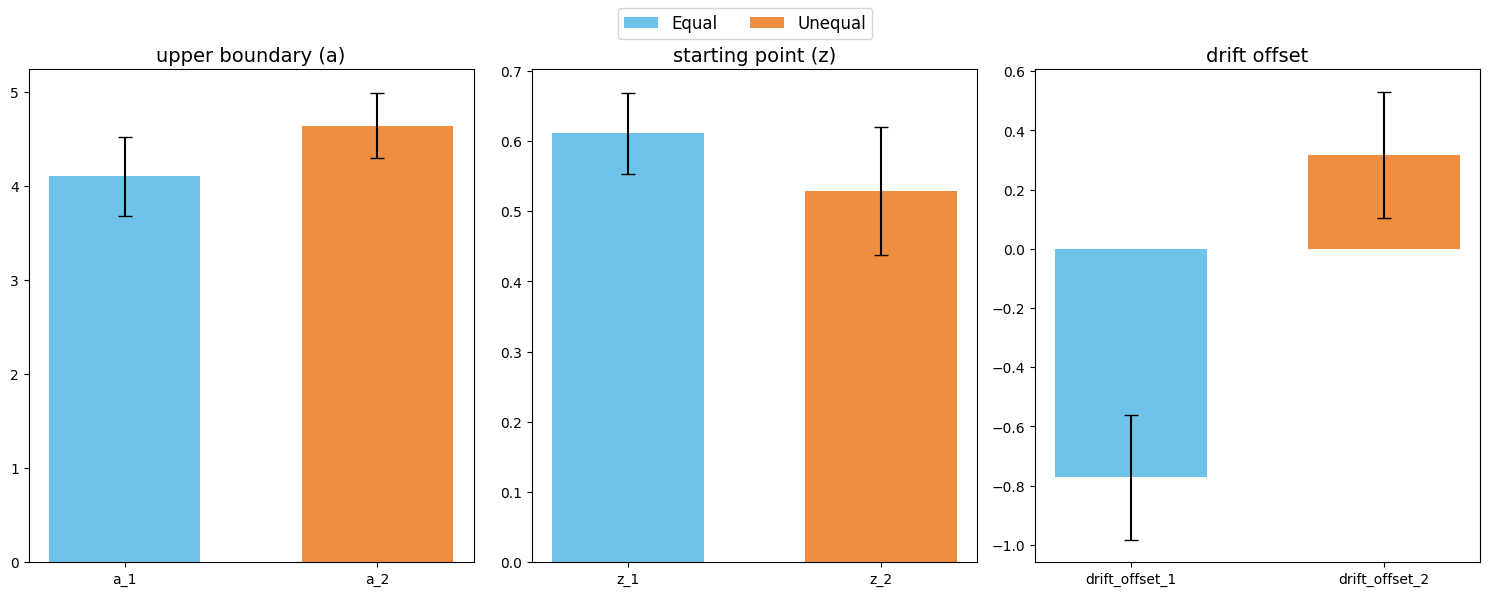

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# your parameters
params_to_plot = ["a", "z", "drift_offset"]
param_names = ["upper boundary (a)", "starting point (z)", "drift offset"]
colors = {"Equal": "#6FC3EB", "Unequal": "#EF8D41"}

nrows, ncols = 1, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 6 * nrows))

for idx_param, param_name in enumerate(params_to_plot):
    if nrows > 1:
        ax = axs[idx_param // ncols, idx_param % ncols]
    else:
        ax = axs[idx_param % ncols]

    param_1 = f"{param_name}_1"
    param_2 = f"{param_name}_2"

    means_1 = params[param_1].mean()
    sems_1 = sem(params[param_1])
    means_2 = params[param_2].mean()
    sems_2 = sem(params[param_2])

    ax.bar(0, means_1, yerr=sems_1, capsize=5, width=0.6, color=colors["Equal"], label="Equal")
    ax.bar(1, means_2, yerr=sems_2, capsize=5, width=0.6, color=colors["Unequal"], label="Unequal")

    ax.set_xticks([0, 1])
    ax.set_xticklabels([param_1, param_2])
    ax.set_title(param_names[idx_param], fontsize=14)

# one shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], loc="upper center", ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.show()


In [38]:
behavior_df.loc[idx_session, "prior_direction"]


'L'

In [ ]:
# Extract fitted parameters from the new API result format
param_values = list(result["parameters"].values())
param_names = list(result["parameters"].keys())
params = np.array(param_values)
param_bounds = model._param_bounds

print("Fitted parameters:")
for name, value in result["parameters"].items():
    print(f"  {name}: {value:.4f}")

print(f"\nTotal parameters: {len(params)}")
print(f"Parameter names: {param_names}")

# Show parameter bounds
print(f"\nParameter bounds:")
for name, (default, bounds) in param_bounds.items():
    print(f"  {name}: {bounds[0]:.3f} - {bounds[1]:.3f}")

print(f"\nFit results:")
print(f"  Success: {result['success']}")
print(f"  Likelihood: {result['likelihood']:.2f}")
print(f"  Iterations: {result['n_iterations']}")

In [ ]:
# Display dual-prior parameter structure
print("Dual-Prior Parameter Structure:")
print("="*40)

global_params = []
equal_params = []
unequal_params = []

for name, value in result["parameters"].items():
    if name.endswith("_1"):
        equal_params.append((name, value))
    elif name.endswith("_2"):
        unequal_params.append((name, value))
    else:
        global_params.append((name, value))

print("Global Parameters (shared between conditions):")
for name, value in global_params:
    print(f"  {name}: {value:.4f}")

print(f"\nEqual Prior Condition Parameters:")
for name, value in equal_params:
    base_name = name[:-2]
    print(f"  {base_name}: {value:.4f}")

print(f"\nUnequal Prior Condition Parameters:")
for name, value in unequal_params:
    base_name = name[:-2]
    print(f"  {base_name}: {value:.4f}")

# Compare prior-specific parameters
print(f"\nParameter Comparison Between Prior Conditions:")
print(f"{'Parameter':<12} {'Equal':<8} {'Unequal':<8} {'Difference':<10}")
print("-" * 40)
equal_dict = {name[:-2]: value for name, value in equal_params}
unequal_dict = {name[:-2]: value for name, value in unequal_params}

for param in equal_dict:
    if param in unequal_dict:
        diff = unequal_dict[param] - equal_dict[param]
        print(f"{param:<12} {equal_dict[param]:<8.4f} {unequal_dict[param]:<8.4f} {diff:<10.4f}")

In [ ]:
# Validate dual-prior data structure
print("Data Validation:")
print("="*30)

session_data = behavior_df[behavior_df.session_id == session_id]
print(f"Session: {session_id}")
print(f"Total trials: {len(session_data)}")

prior_counts = session_data['prior_block'].value_counts()
print(f"\nPrior block distribution:")
for prior, count in prior_counts.items():
    print(f"  {prior}: {count} trials ({100*count/len(session_data):.1f}%)")

print(f"\nCoherence distribution by prior:")
for prior in ['equal', 'unequal']:
    prior_data = session_data[session_data['prior_block'] == prior]
    if len(prior_data) > 0:
        coherences = prior_data['signed_coherence'].unique()
        print(f"  {prior}: {len(coherences)} unique coherences")
        print(f"    Range: [{coherences.min():.1f}, {coherences.max():.1f}]")

print(f"\nRT statistics by prior:")
for prior in ['equal', 'unequal']:
    prior_data = session_data[session_data['prior_block'] == prior]
    if len(prior_data) > 0:
        rt_stats = prior_data['rt'].describe()
        print(f"  {prior}: mean={rt_stats['mean']:.3f}s, std={rt_stats['std']:.3f}s")

print(f"\nChoice distribution by prior:")
for prior in ['equal', 'unequal']:
    prior_data = session_data[session_data['prior_block'] == prior]
    if len(prior_data) > 0:
        choice_mean = prior_data['choice'].mean()
        print(f"  {prior}: {choice_mean:.3f} (proportion rightward choices)")

In [23]:
def simulate_ddm(idx_prior, model, result_dict, stimulus, enable_leak=False, enable_time_dependence=False):
    """
    Simulate DDM for a specific prior condition using fitted parameters.

    Args:
        idx_prior: 0 for 'equal' prior, 1 for 'unequal' prior
        model: The fitted DecisionModel instance
        result_dict: Dictionary containing fitted parameters
        stimulus: Stimulus array for this prior condition
        enable_leak: Whether leak was enabled in fitting
        enable_time_dependence: Whether time dependence was enabled in fitting

    Returns:
        DataFrame with simulated data
    """
    # Get parameters from the result dictionary
    parameters = result_dict["parameters"]

    # Update model parameters for this specific prior condition
    param_names = list(parameters.keys())

    for param_name, param_value in parameters.items():
        if param_name.endswith(f"_{idx_prior + 1}"):
            # Prior-specific parameter (remove suffix)
            base_name = param_name[:-2]
            setattr(model.simulator, base_name, param_value)
            print(f"{base_name} (prior {idx_prior + 1}): {param_value:.4f}")
        elif "_" not in param_name or not param_name[-1].isdigit():
            # Global parameter
            setattr(model.simulator, param_name, param_value)
            print(f"{param_name} (global): {param_value:.4f}")

    # Simulate trials using the model's simulate method
    sim_result = model.simulate(stimulus, n_reps=1)

    # Create DataFrame of simulated data
    model_sim = pd.DataFrame({
        "signed_coherence": sim_result["coherence"] * 100,  # Convert back to original scale
        "choice": sim_result["choice"],
        "rt": sim_result["rt"],
    })

    return model_sim

In [24]:
def plot_ddm_fit(model_sim, data):
    # Get psychometric and chronometric data for both real and simulated data
    x_data, y_data = get_psychometric_data(data)
    _, rt_median, rt_mean, rt_sd, _ = get_chronometric_data(data)
    x_model, y_model = get_psychometric_data(model_sim)
    _, rt_median_model, rt_mean_model, rt_sd_model, _ = get_chronometric_data(model_sim)

    # Plotting
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(2, 2)

    # Psychometric plot (proportion choice)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(x_data, y_data, "o", color="k", label="data")
    ax1.plot(x_model, y_model, "o", color="b", label="model")
    ax1.set_ylim(-0.1, 1.1)
    ax1.legend()

    # Chronometric plot (RT means)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(x_data, rt_mean, "o", color="k", label="data")
    ax2.fill_between(x_data, rt_mean - rt_sd, rt_mean + rt_sd, color="k", alpha=0.2)
    ax2.fill_between(x_model, rt_mean_model - rt_sd_model, rt_mean_model + rt_sd_model, color="b", alpha=0.2)
    ax2.plot(x_model, rt_mean_model, "o", color="b", label="model", markersize=8)
    ax2.legend()

    # ax3 = fig.add_subplot(gs[1, :])
    # ax3.plot(dv.T, color="k", alpha=0.1)

    plt.tight_layout()
    plt.show()

    # Print proportion of invalid trials (NaN choices)
    print("Proportion of invalid trials:", np.mean(np.isnan(model_sim["choice"])))

    # return model_sim, ddm


Fitting session 210126_GP_JP

Session: 210126_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 448 trials
ndt (global): 0.2399
drift_gain (global): 11.1183
variance (global): 2.4168
a (prior 1): 5.0351
z (prior 1): 0.3649
drift_offset (prior 1): 0.8848
leak_rate (global): 0.5238
time_constant (global): 0.0161

Simulation completed. Generated 448 trials.
Valid simulated trials: 448


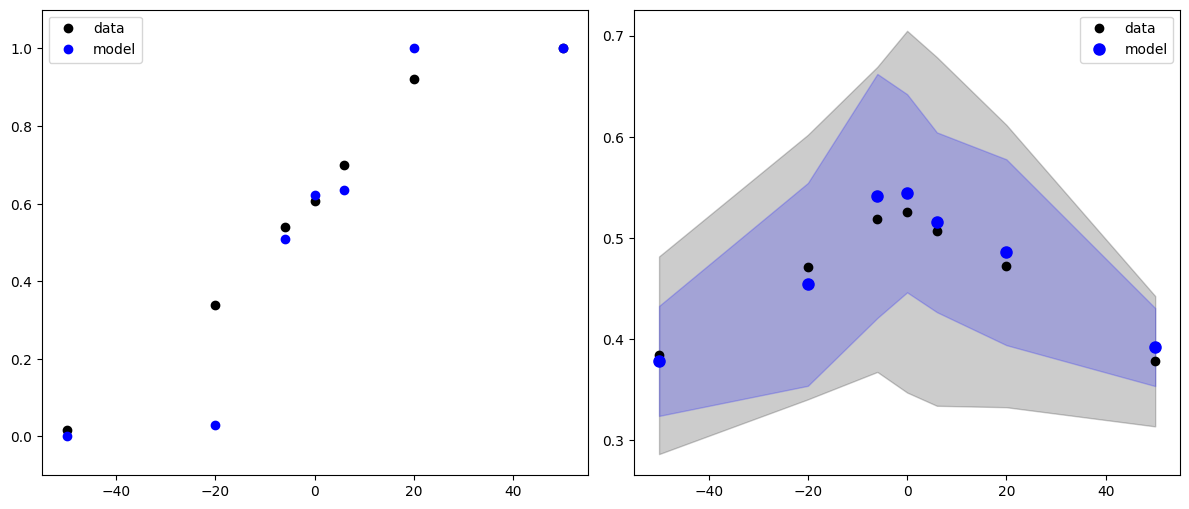

Proportion of invalid trials: 0.0

Session: 210126_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 613 trials
ndt (global): 0.2399
drift_gain (global): 11.1183
variance (global): 2.4168
a (prior 2): 4.7785
z (prior 2): 0.5005
drift_offset (prior 2): -1.2265
leak_rate (global): 0.5238
time_constant (global): 0.0161

Simulation completed. Generated 613 trials.
Valid simulated trials: 613


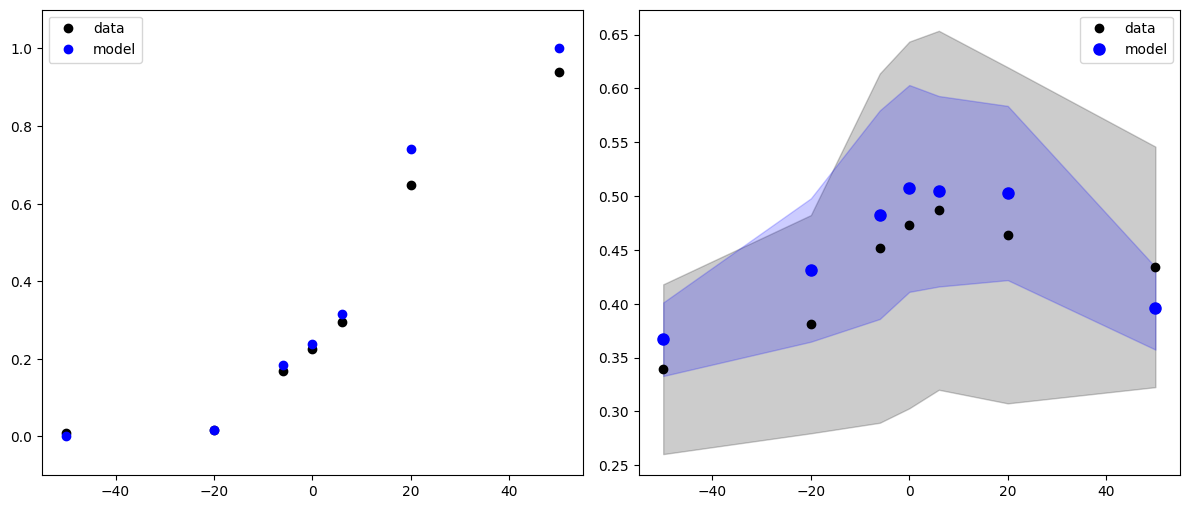

Proportion of invalid trials: 0.0
Fitting session 210205_GP_JP

Session: 210205_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 347 trials
ndt (global): 0.2375
drift_gain (global): 15.9591
variance (global): 3.3688
a (prior 1): 4.2187
z (prior 1): 0.2328
drift_offset (prior 1): 0.5611
leak_rate (global): 0.2819
time_constant (global): 0.0019

Simulation completed. Generated 347 trials.
Valid simulated trials: 347


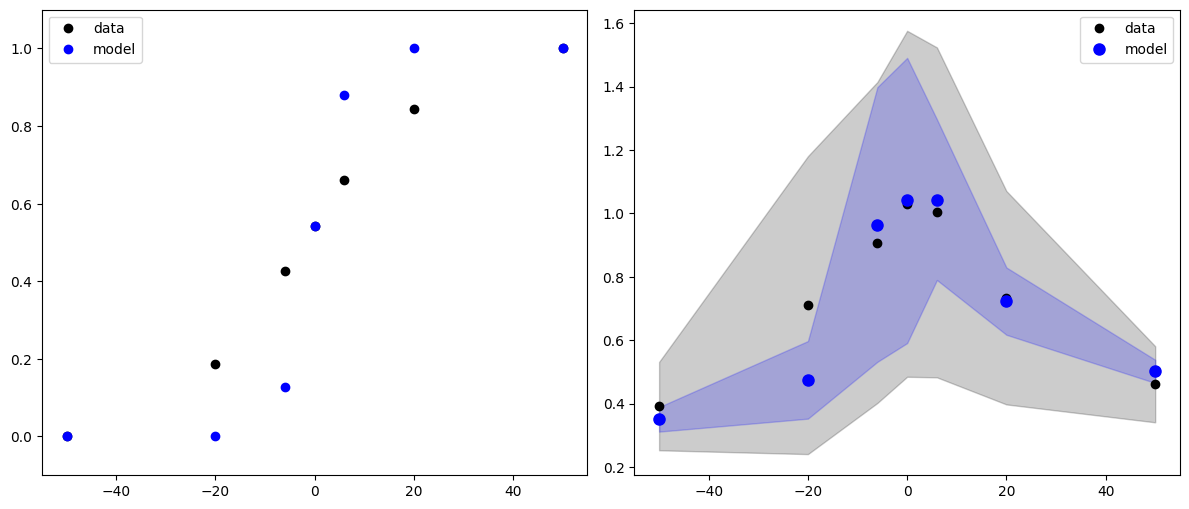

Proportion of invalid trials: 0.0

Session: 210205_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 618 trials
ndt (global): 0.2375
drift_gain (global): 15.9591
variance (global): 3.3688
a (prior 2): 3.5459
z (prior 2): 0.1648
drift_offset (prior 2): 0.3012
leak_rate (global): 0.2819
time_constant (global): 0.0019

Simulation completed. Generated 618 trials.
Valid simulated trials: 618


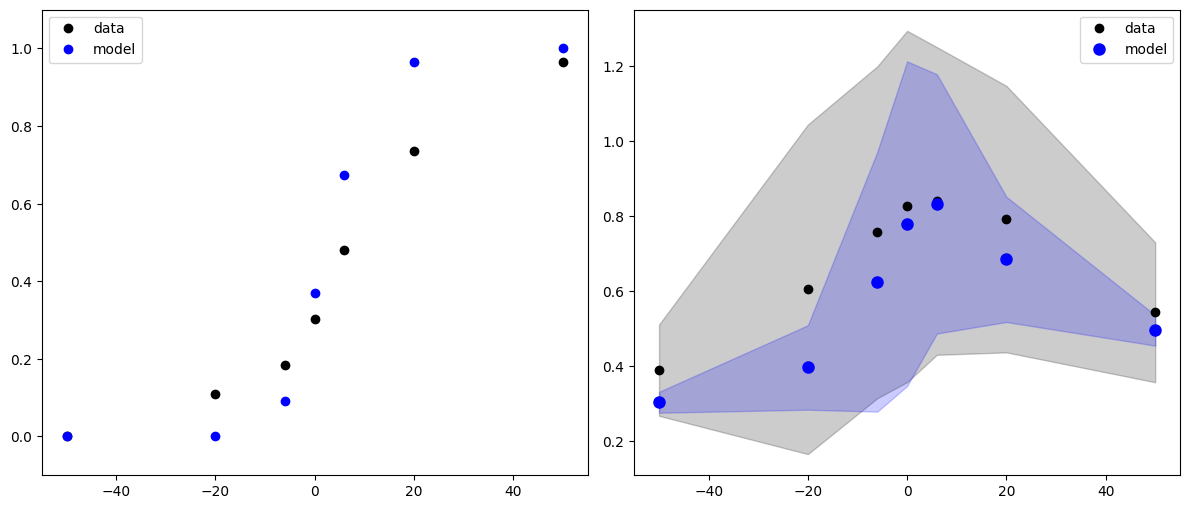

Proportion of invalid trials: 0.0
Fitting session 210210_GP_JP

Session: 210210_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 334 trials
ndt (global): 0.2037
drift_gain (global): 7.0979
variance (global): 3.4302
a (prior 1): 5.4576
z (prior 1): 0.2833
drift_offset (prior 1): -0.0202
leak_rate (global): 0.2560
time_constant (global): 0.0040

Simulation completed. Generated 334 trials.
Valid simulated trials: 334


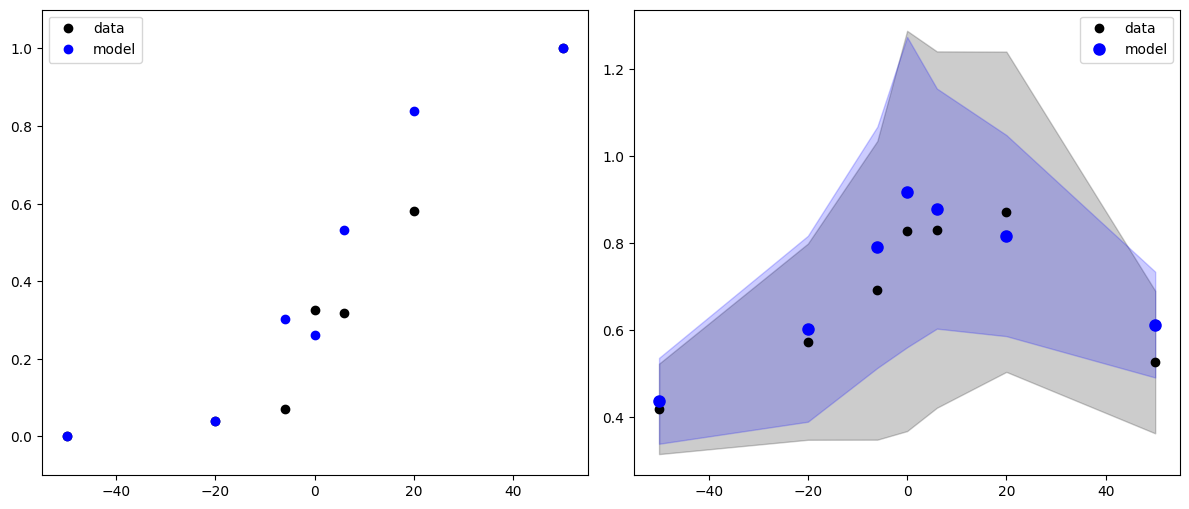

Proportion of invalid trials: 0.0

Session: 210210_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 589 trials
ndt (global): 0.2037
drift_gain (global): 7.0979
variance (global): 3.4302
a (prior 2): 5.4696
z (prior 2): 0.2153
drift_offset (prior 2): 0.3496
leak_rate (global): 0.2560
time_constant (global): 0.0040

Simulation completed. Generated 589 trials.
Valid simulated trials: 589


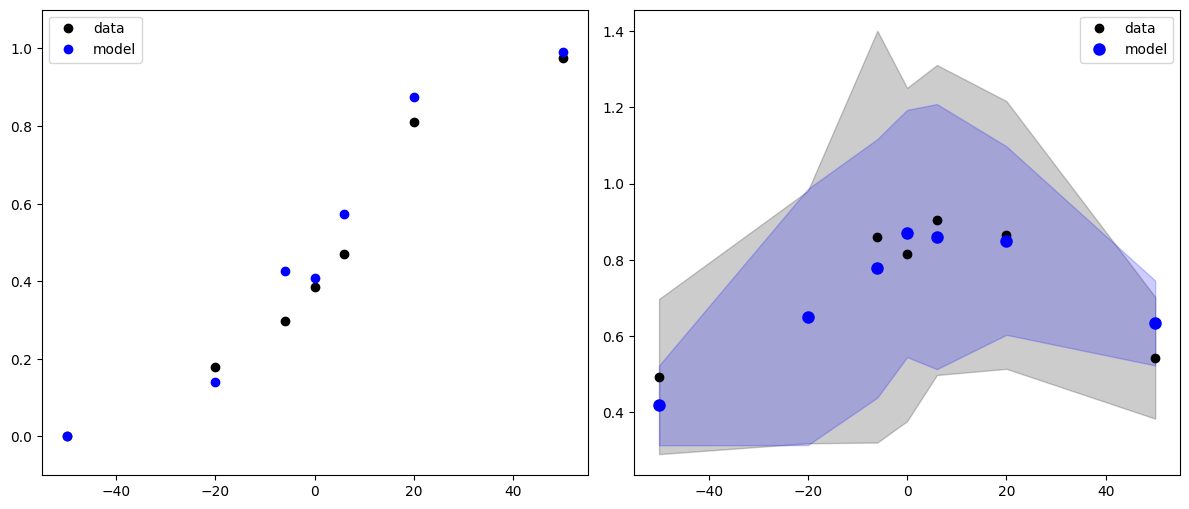

Proportion of invalid trials: 0.0
Fitting session 210211_GP_JP

Session: 210211_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 349 trials
ndt (global): 0.2122
drift_gain (global): 2.8372
variance (global): 2.2099
a (prior 1): 3.6739
z (prior 1): 0.3959
drift_offset (prior 1): 0.2902
leak_rate (global): 0.5815
time_constant (global): 0.0021

Simulation completed. Generated 349 trials.
Valid simulated trials: 349


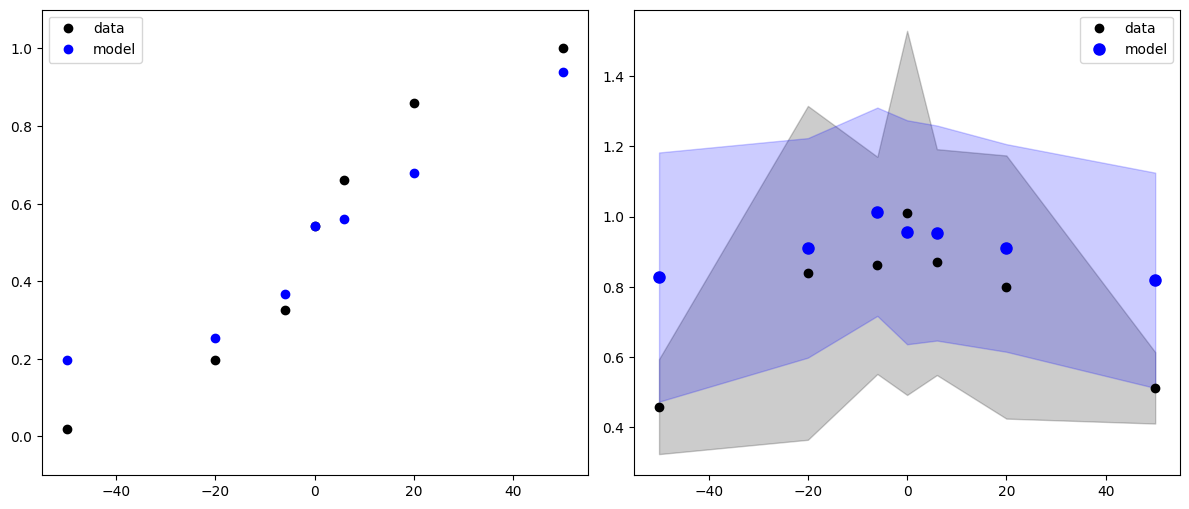

Proportion of invalid trials: 0.0

Session: 210211_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 594 trials
ndt (global): 0.2122
drift_gain (global): 2.8372
variance (global): 2.2099
a (prior 2): 5.2331
z (prior 2): 0.2297
drift_offset (prior 2): 1.3509
leak_rate (global): 0.5815
time_constant (global): 0.0021

Simulation completed. Generated 594 trials.
Valid simulated trials: 593


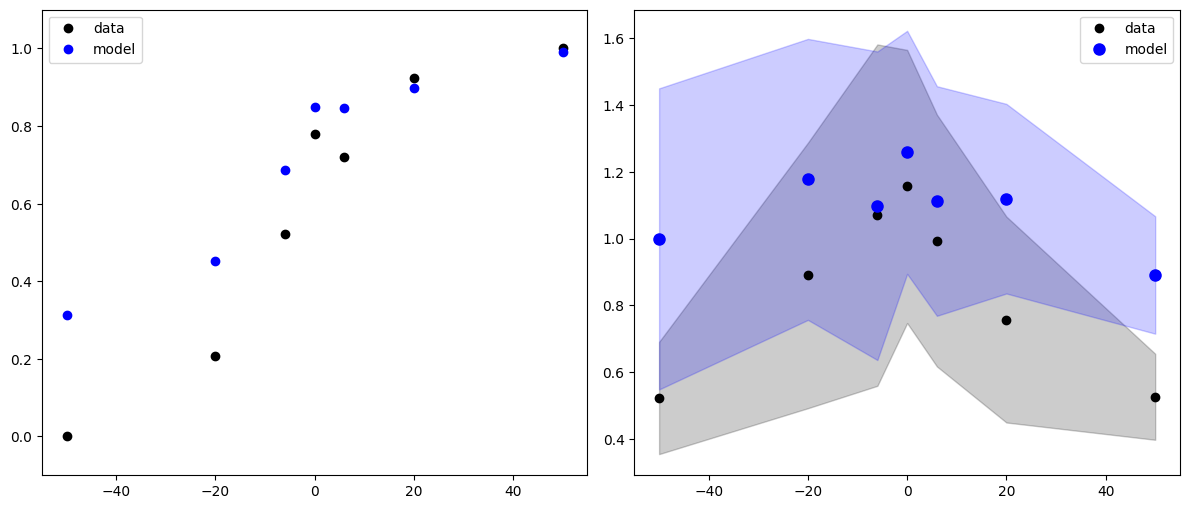

Proportion of invalid trials: 0.0016835016835016834
Fitting session 210217_GP_JP

Session: 210217_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 399 trials
ndt (global): 0.1843
drift_gain (global): 5.1151
variance (global): 2.7038
a (prior 1): 5.2312
z (prior 1): 0.1918
drift_offset (prior 1): 1.1230
leak_rate (global): 0.3577
time_constant (global): 0.0031

Simulation completed. Generated 399 trials.
Valid simulated trials: 399


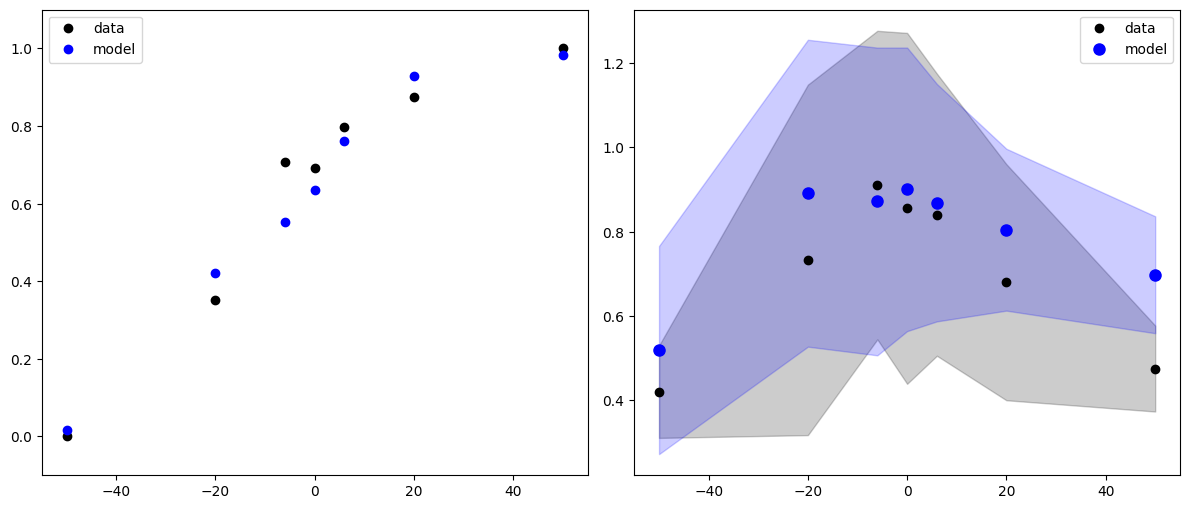

Proportion of invalid trials: 0.0

Session: 210217_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 593 trials
ndt (global): 0.1843
drift_gain (global): 5.1151
variance (global): 2.7038
a (prior 2): 5.4367
z (prior 2): 0.1693
drift_offset (prior 2): 0.2276
leak_rate (global): 0.3577
time_constant (global): 0.0031

Simulation completed. Generated 593 trials.
Valid simulated trials: 593


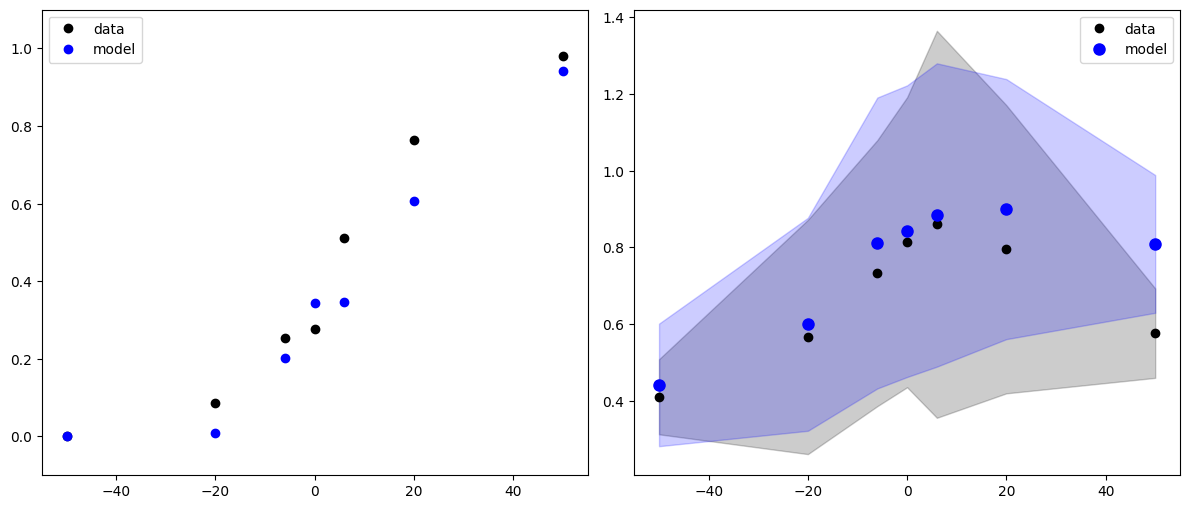

Proportion of invalid trials: 0.0
Fitting session 210224_GP_JP

Session: 210224_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 492 trials
ndt (global): 0.1714
drift_gain (global): 9.0120
variance (global): 3.0939
a (prior 1): 2.5927
z (prior 1): 0.5600
drift_offset (prior 1): -1.4721
leak_rate (global): 0.1931
time_constant (global): 0.0034

Simulation completed. Generated 492 trials.
Valid simulated trials: 492


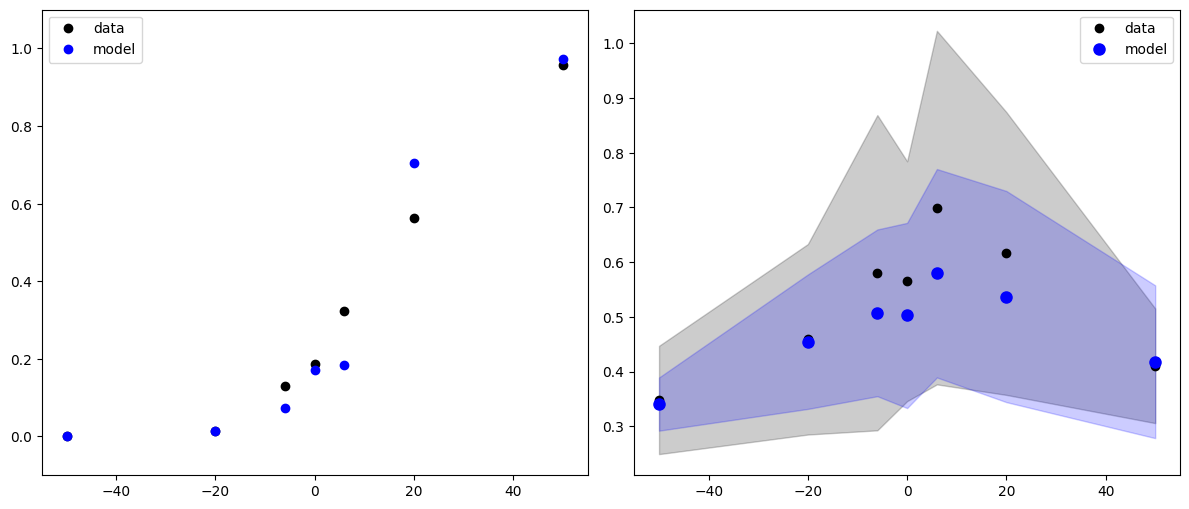

Proportion of invalid trials: 0.0

Session: 210224_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 797 trials
ndt (global): 0.1714
drift_gain (global): 9.0120
variance (global): 3.0939
a (prior 2): 5.5424
z (prior 2): 0.1953
drift_offset (prior 2): 0.7304
leak_rate (global): 0.1931
time_constant (global): 0.0034

Simulation completed. Generated 797 trials.
Valid simulated trials: 797


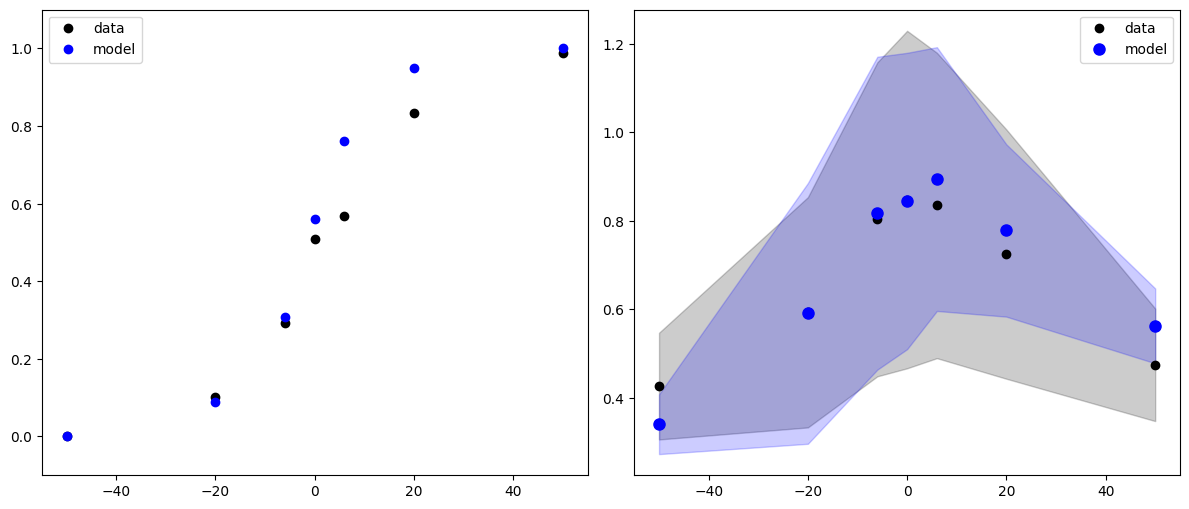

Proportion of invalid trials: 0.0
Fitting session 210302_GP_JP

Session: 210302_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 353 trials
ndt (global): 0.1383
drift_gain (global): 13.2092
variance (global): 4.0904
a (prior 1): 4.7803
z (prior 1): 0.3536
drift_offset (prior 1): 0.4768
leak_rate (global): 0.0472
time_constant (global): 0.0037

Simulation completed. Generated 353 trials.
Valid simulated trials: 353


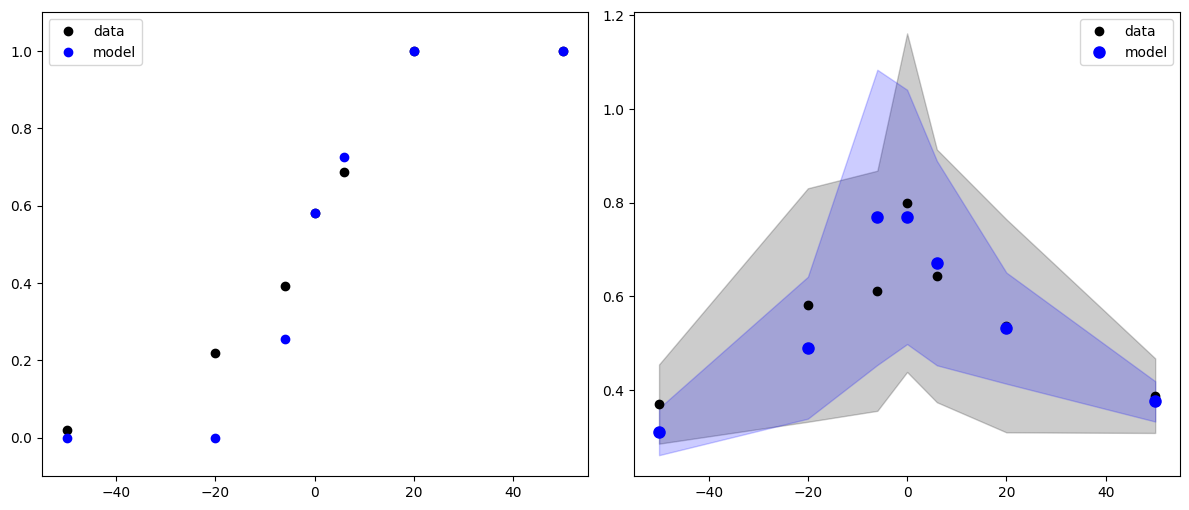

Proportion of invalid trials: 0.0

Session: 210302_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 691 trials
ndt (global): 0.1383
drift_gain (global): 13.2092
variance (global): 4.0904
a (prior 2): 4.3681
z (prior 2): 0.3554
drift_offset (prior 2): 0.1663
leak_rate (global): 0.0472
time_constant (global): 0.0037

Simulation completed. Generated 691 trials.
Valid simulated trials: 691


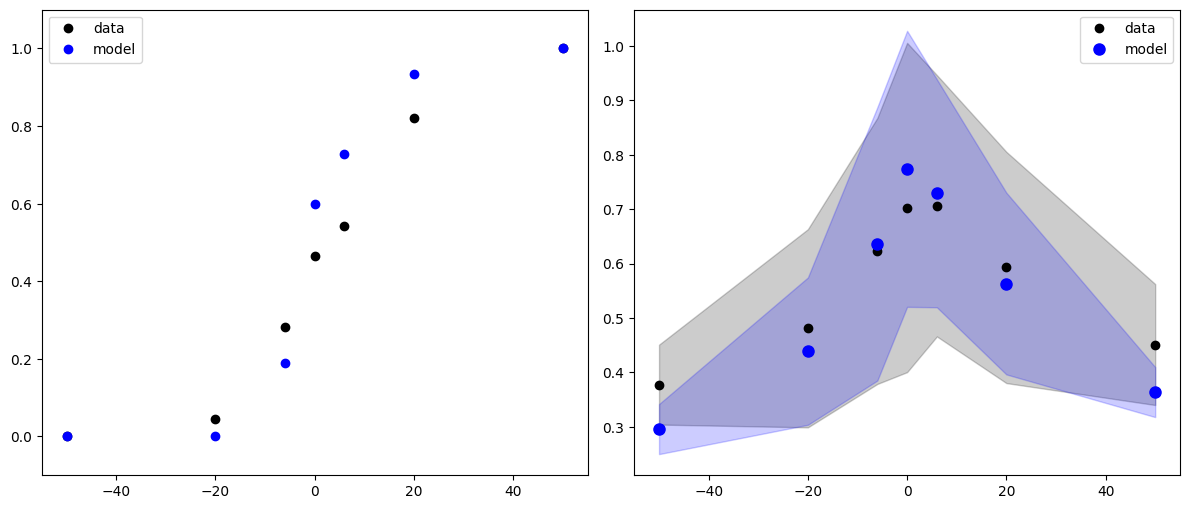

Proportion of invalid trials: 0.0
Fitting session 210305_GP_JP

Session: 210305_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 354 trials
ndt (global): 0.2610
drift_gain (global): 19.9885
variance (global): 0.9359
a (prior 1): 4.2073
z (prior 1): 0.2587
drift_offset (prior 1): 1.5357
leak_rate (global): 0.0047
time_constant (global): 0.0020

Simulation completed. Generated 354 trials.
Valid simulated trials: 354


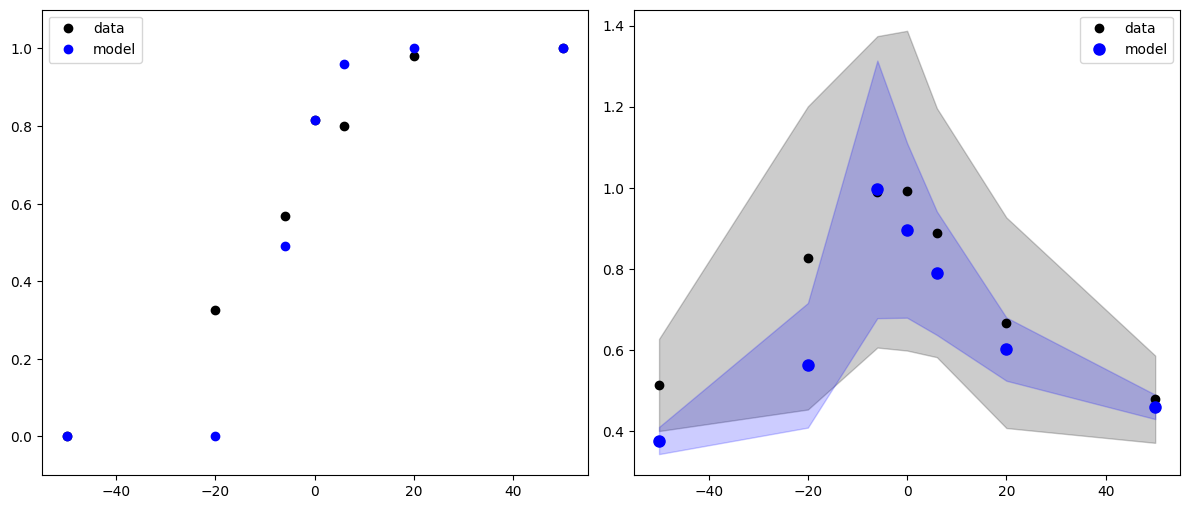

Proportion of invalid trials: 0.0

Session: 210305_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 700 trials
ndt (global): 0.2610
drift_gain (global): 19.9885
variance (global): 0.9359
a (prior 2): 4.9898
z (prior 2): 0.1701
drift_offset (prior 2): 0.1632
leak_rate (global): 0.0047
time_constant (global): 0.0020

Simulation completed. Generated 700 trials.
Valid simulated trials: 700


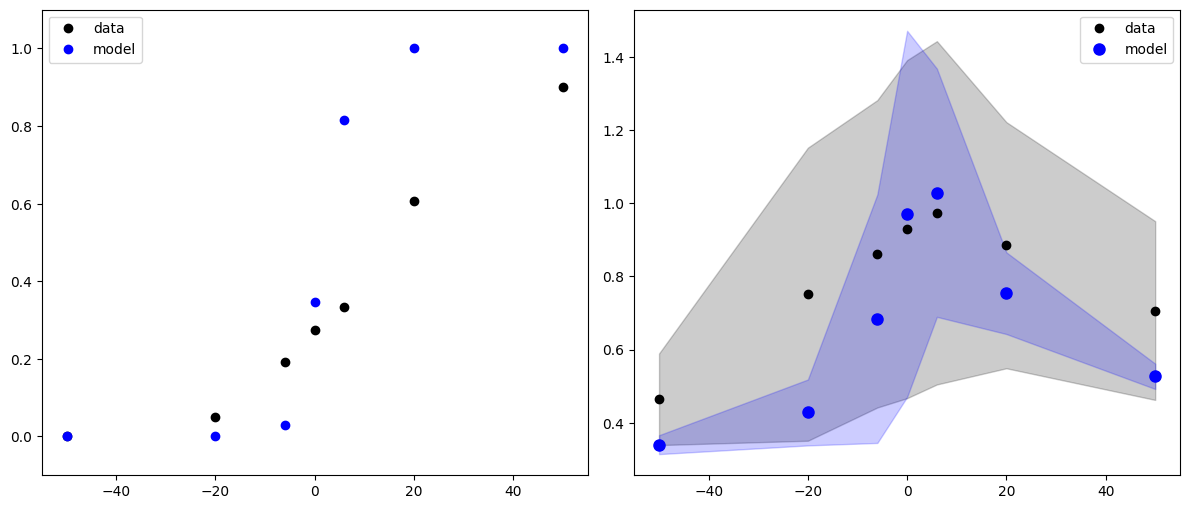

Proportion of invalid trials: 0.0
Fitting session 210311_GP_JP

Session: 210311_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 356 trials
ndt (global): 0.3096
drift_gain (global): 5.4687
variance (global): 3.6881
a (prior 1): 1.7295
z (prior 1): 0.6620
drift_offset (prior 1): -1.1692
leak_rate (global): 0.3299
time_constant (global): 0.0054

Simulation completed. Generated 356 trials.
Valid simulated trials: 356


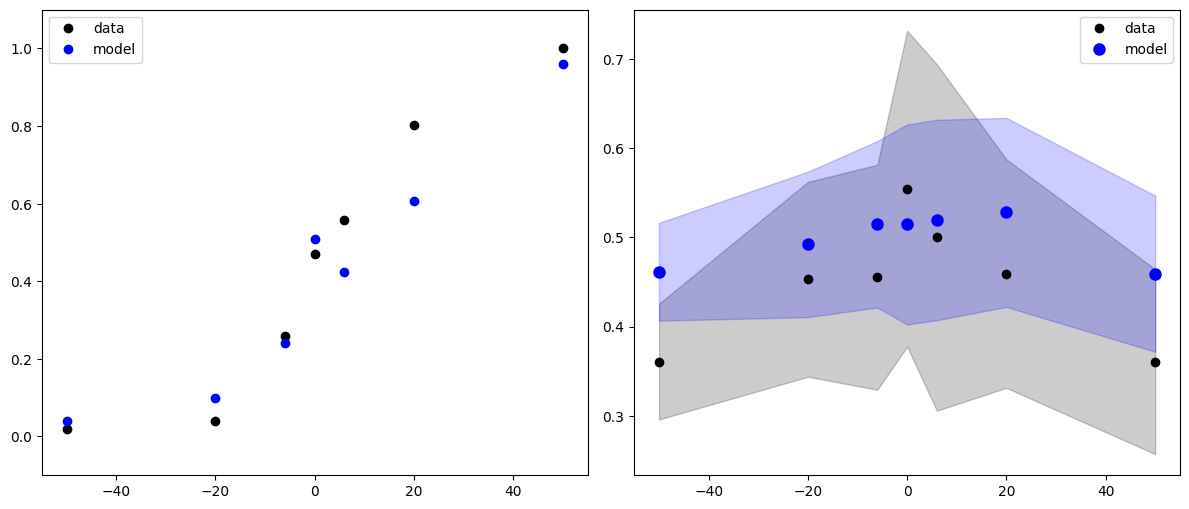

Proportion of invalid trials: 0.0

Session: 210311_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 764 trials
ndt (global): 0.3096
drift_gain (global): 5.4687
variance (global): 3.6881
a (prior 2): 2.4348
z (prior 2): 0.4811
drift_offset (prior 2): 0.0583
leak_rate (global): 0.3299
time_constant (global): 0.0054

Simulation completed. Generated 764 trials.
Valid simulated trials: 764


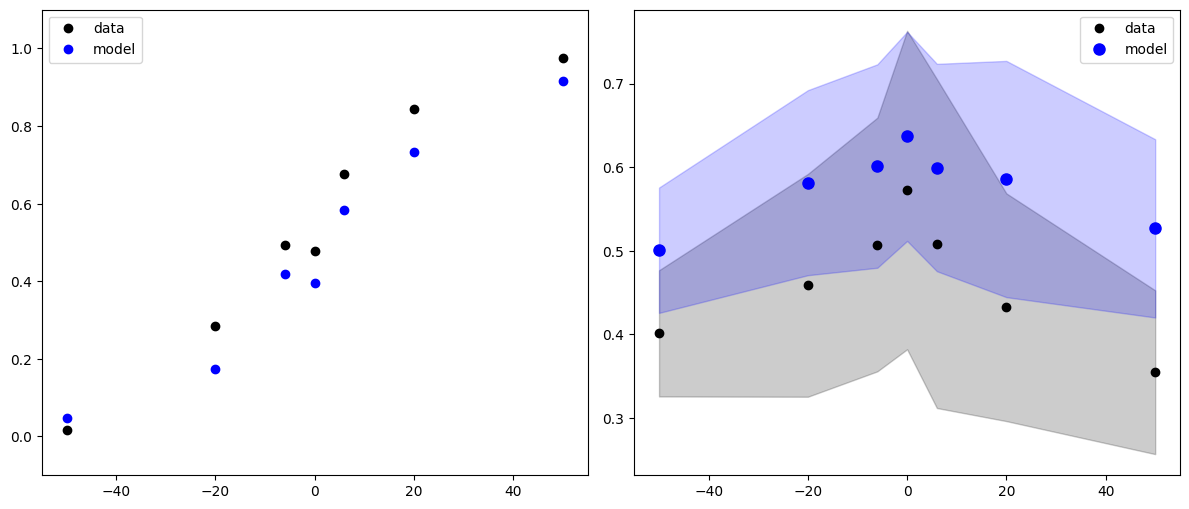

Proportion of invalid trials: 0.0


In [25]:
for idx_session, session_id in enumerate(session_ids):
    print(f"Fitting session {session_id}")
    data = behavior_df[(behavior_df.session_id == session_id)]
    data = data[["signed_coherence", "choice", "rt", "prior_block"]]
    data["choice"] = data["choice"].astype(int)

    # Get stimulus length
    stimulus_length = int(np.max(data["rt"]) * 1000)
    stimulus = np.tile(data["signed_coherence"].to_numpy().reshape(-1, 1), (1, stimulus_length)) / 100  # range[-1,1]

    # Simulate and plot for each prior condition
    for idx_prior, prior in enumerate(["equal", "unequal"]):
        print(f"\n{'='*50}")
        print(f"Session: {session_id}, Prior: {prior} (idx: {idx_prior})")
        print(f"{'='*50}")

        # Filter data and stimulus for this prior condition
        prior_mask = data["prior_block"] == prior
        prior_data = data[prior_mask].reset_index(drop=True)
        prior_stimulus = stimulus[prior_mask]

        if len(prior_data) == 0:
            print(f"No data found for prior condition: {prior}")
            continue

        print(f"Prior condition '{prior}' has {len(prior_data)} trials")

        # Simulate with parameters fitted for this prior condition
        model_sim = simulate_ddm(idx_prior, models[idx_session], results[idx_session], prior_stimulus, enable_leak=enable_leak, enable_time_dependence=enable_time_dependence)

        print(f"\nSimulation completed. Generated {len(model_sim)} trials.")
        print(f"Valid simulated trials: {np.sum(~np.isnan(model_sim['choice']))}")

        # Plot comparison
        plot_ddm_fit(model_sim, prior_data)